In [2]:
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('house-prices-advanced-regression-techniques/preprocessed.csv')
df.head()

,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.071562,0.370295,-0.264868,-0.678432,-0.301189,0.435239,0.227107,0.312313,1.232693,0.707029,...,0.298465,-0.364226,-0.033312,-0.253081,-0.144348,-1.606014,0.137217,-0.243548,-0.16588,0.479517
1,-0.870615,0.370295,0.008674,-0.678432,-0.497470,0.651974,-2.322601,0.312313,-0.190100,-0.038110,...,-0.749164,-0.364226,-0.033312,-0.253081,-0.144348,-0.495788,-0.618051,-0.243548,-0.16588,0.091359
2,0.071562,0.370295,0.401148,1.091978,-0.301189,0.435239,0.227107,0.312313,1.232693,0.707029,...,-0.027846,-0.364226,-0.033312,-0.253081,-0.144348,0.984513,0.137217,-0.243548,-0.16588,0.695160
3,0.071562,0.370295,1.117115,1.091978,-0.497470,2.401165,0.227107,0.312313,1.232693,1.452168,...,0.693472,-0.364226,-0.033312,-0.253081,-0.144348,2.094739,0.137217,-0.243548,-0.16588,1.076129
4,-0.870615,0.370295,0.123800,-0.678432,-0.301189,0.930463,0.227107,0.312313,-0.190100,1.452168,...,0.229768,-0.364226,-0.033312,-0.253081,-0.144348,0.614438,-0.618051,-0.243548,-0.16588,1.895573


In [4]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category")
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. Feature Selection

### 2.1 Basic selection

In [18]:
corr_matr = df.corr().abs()
upper_tri = corr_matr.where(np.triu(np.ones(corr_matr.shape), k=1).astype(bool))

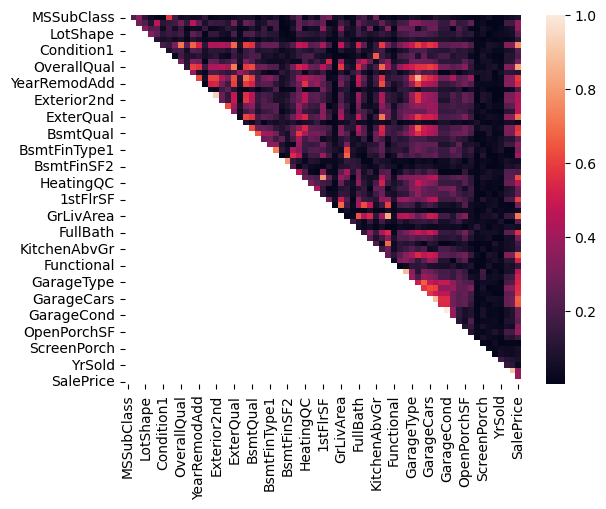

In [19]:
import seaborn as sns

plt.figure()
sns.heatmap(upper_tri)
plt.show()

In [20]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop)

df1 = df.drop(to_drop, axis=1)

['Exterior2nd', 'GarageCond']


### 2.2 Shap on XGBoost

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [22]:
import xgboost as xgb

base_model_xgb = xgb.XGBRegressor()

scores_xgb = cross_val_score(base_model_xgb, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_xgb = np.sqrt(-scores_xgb)

print(f'Mean RMSE: {rmse_xgb.mean()}')

Mean RMSE: 0.32108733736477085


In [23]:
import shap

base_model_xgb.fit(X, y)

explainer = shap.TreeExplainer(base_model_xgb)
shap_values_xgb = explainer.shap_values(X)

mean_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)
importance_df_xgb = pd.DataFrame({
    "feature": X.columns.values,
    "importance": mean_shap_xgb
}).sort_values('importance', ascending=False)

importance_df_xgb.head(20)

,feature,importance
9,OverallQual,0.395564
36,GrLivArea,0.185727
5,Neighborhood,0.106541
29,TotalBsmtSF,0.058141
25,BsmtFinSF1,0.051472
51,GarageCars,0.039220
33,1stFlrSF,0.037795
10,OverallCond,0.034810
43,KitchenQual,0.033266
2,LotArea,0.032202


In [24]:
most_rel_feat_xgb = importance_df_xgb['feature'].values[:20].tolist()
print(most_rel_feat_xgb)

['OverallQual', 'GrLivArea', 'Neighborhood', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageCars', '1stFlrSF', 'OverallCond', 'KitchenQual', 'LotArea', 'GarageArea', 'BsmtFinType1', 'YearBuilt', 'FireplaceQu', 'BsmtFullBath', 'GarageType', 'YearRemodAdd', 'BsmtUnfSF', '2ndFlrSF', 'ExterQual']


Mean RMSE: 0.3237777263349414


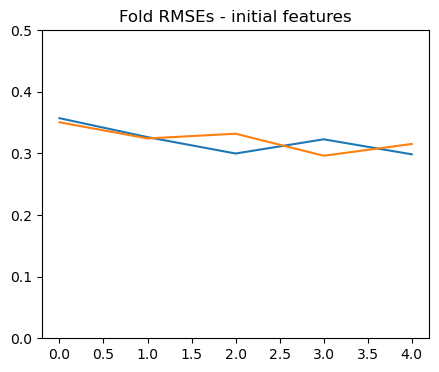

In [25]:
import xgboost as xgb

model = xgb.XGBRegressor()

scores_xgb_2 = cross_val_score(model, X[most_rel_feat_xgb], y, cv=kf, scoring='neg_mean_squared_error')
rmse_xgb_2 = np.sqrt(-scores_xgb_2)

print(f'Mean RMSE: {rmse_xgb_2.mean()}')

plt.figure(figsize=(5,4))
plt.title('Fold RMSEs - initial features')
plt.ylim(0, 0.5)
plt.plot(rmse_xgb)
plt.plot(rmse_xgb_2)
plt.show()

### 2.3 Shap on SVR

In [26]:
from sklearn.svm import SVR

base_model_svr = SVR()

scores_svm = cross_val_score(base_model_svr, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_svm = np.sqrt(-scores_svm)

print(f'Mean RMSE: {rmse_svm.mean()}')

Mean RMSE: 0.3324897478319556


In [27]:
import shap

base_model_svr.fit(X,y)
X_summary = shap.kmeans(X_train, 10)

explainer = shap.KernelExplainer(base_model_svr.predict, X_summary)

shap_values_svm = explainer.shap_values(X_test[:100])

mean_shap_svm = np.abs(shap_values_svm).mean(axis=0)
importance_df_svm = pd.DataFrame({
    "feature": X.columns.values,
    "importance": mean_shap_svm
}).sort_values('importance', ascending=False)

importance_df_svm.head(20)

 39%|███▉      | 39/100 [01:05<01:42,  1.68s/it]


KeyboardInterrupt: 

In [ ]:
most_rel_feat_svm = importance_df_svm['feature'].values[:20].tolist()
print(most_rel_feat_svm)

['GrLivArea', 'OverallQual', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'Neighborhood', 'BsmtFinSF1', 'OverallCond', 'MSZoning', 'GarageCars', 'GarageArea', 'KitchenQual', 'YearBuilt', 'BsmtQual', 'LotArea', 'BsmtFinType1', 'SaleCondition', 'FullBath', 'YearRemodAdd', 'GarageFinish']


Mean RMSE: 0.3227997349249253


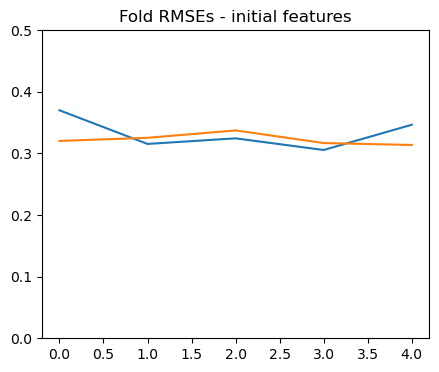

In [ ]:
from sklearn.svm import SVR

base_model_svr = SVR()

scores_svm_2 = cross_val_score(base_model_svr, X[most_rel_feat_svm], y, cv=kf, scoring='neg_mean_squared_error')
rmse_svm_2 = np.sqrt(-scores_svm_2)

print(f'Mean RMSE: {rmse_svm_2.mean()}')

plt.figure(figsize=(5,4))
plt.title('Fold RMSEs - initial features')
plt.ylim(0, 0.5)
plt.plot(rmse_svm)
plt.plot(rmse_svm_2)
plt.show()

### 2.4 Cumulative importance

In [ ]:
importance_df = pd.DataFrame({
    'feature': importance_df_svm['feature'],
    'importance_svm': importance_df_svm['importance'],
    'importance_xgb': importance_df_xgb['importance']
})

importance_df['rank_svm'] = importance_df['importance_svm'].rank(ascending=False, method='min')
importance_df['rank_xgb'] = importance_df['importance_xgb'].rank(ascending=False, method='min')

importance_df['rank_sum'] = importance_df['rank_svm'] + importance_df['rank_xgb']
importance_df = importance_df.sort_values('rank_sum', ascending=True)

importance_df.head(20)

,feature,importance_svm,importance_xgb,rank_svm,rank_xgb,rank_sum
9,OverallQual,0.094886,0.395564,2.0,1.0,3.0
36,GrLivArea,0.123045,0.185727,1.0,2.0,3.0
5,Neighborhood,0.043817,0.106541,6.0,3.0,9.0
29,TotalBsmtSF,0.059907,0.058141,5.0,4.0,9.0
33,1stFlrSF,0.067188,0.037795,4.0,7.0,11.0
25,BsmtFinSF1,0.035700,0.051472,7.0,5.0,12.0
51,GarageCars,0.027942,0.039220,10.0,6.0,16.0
10,OverallCond,0.035052,0.034810,8.0,8.0,16.0
43,KitchenQual,0.019291,0.033266,12.0,9.0,21.0
34,2ndFlrSF,0.074338,0.014521,3.0,19.0,22.0


In [ ]:
most_rel_feat = importance_df['feature'].values[:20].tolist()
print(most_rel_feat)

['OverallQual', 'GrLivArea', 'Neighborhood', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', 'GarageCars', 'OverallCond', 'KitchenQual', '2ndFlrSF', 'GarageArea', 'LotArea', 'YearBuilt', 'BsmtFinType1', 'YearRemodAdd', 'SaleCondition', 'BsmtQual', 'Condition1', 'ExterQual', 'Exterior1st']


In [1]:
most_rel_feat = ['OverallQual', 'GrLivArea', 'Neighborhood', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', 'GarageCars', 'OverallCond', 'KitchenQual', '2ndFlrSF', 'GarageArea', 'LotArea', 'YearBuilt', 'BsmtFinType1', 'YearRemodAdd']

Mean RMSE XGB: 0.3244232036461982
Mean RMSE SVM: 0.3253218175799371


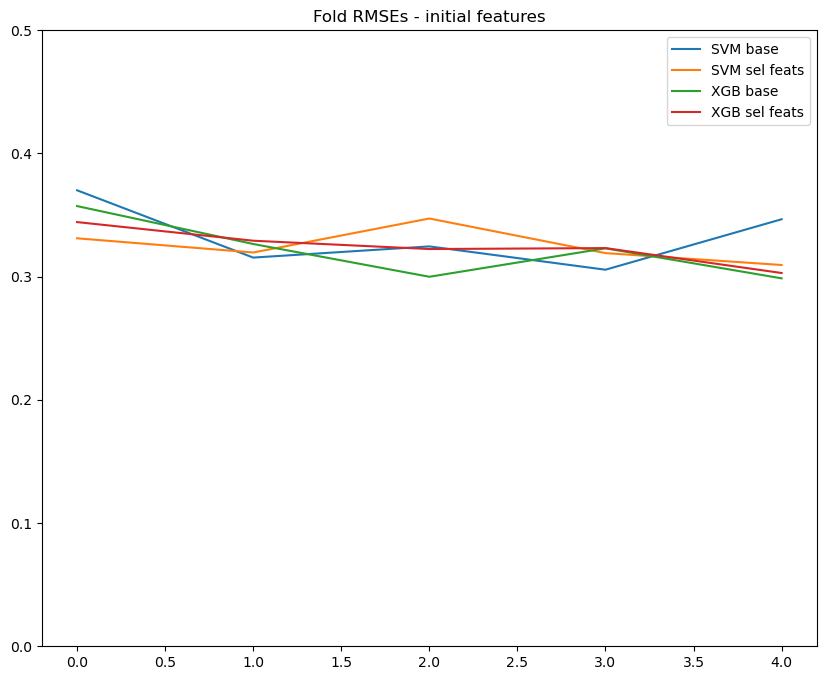

In [ ]:
from sklearn.svm import SVR
import xgboost as xgb

base_model_svr = SVR()

scores_xgb_3 = cross_val_score(base_model_xgb, X[most_rel_feat], y, cv=kf, scoring='neg_mean_squared_error')
scores_svm_3 = cross_val_score(base_model_svr, X[most_rel_feat], y, cv=kf, scoring='neg_mean_squared_error')

rmse_xgb_3 = np.sqrt(-scores_xgb_3)
rmse_svm_3 = np.sqrt(-scores_svm_3)

print(f'Mean RMSE XGB: {rmse_xgb_3.mean()}')
print(f'Mean RMSE SVM: {rmse_svm_3.mean()}')

plt.figure(figsize=(10,8))
plt.title('Fold RMSEs - initial features')
plt.ylim(0, 0.5)

plt.plot(rmse_svm)
plt.plot(rmse_svm_3)
plt.plot(rmse_xgb)
plt.plot(rmse_xgb_3)

plt.legend([
    "SVM base",
    "SVM sel feats",
    "XGB base",
    "XGB sel feats"
])

plt.show()

In [50]:
X_sel = X[most_rel_feat]

## 3. Model Optimization

In [5]:
import optuna
from sklearn.model_selection import cross_val_score

from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank

def optimization_plots(study):
    # fig1 = plot_optimization_history(study)
    # fig1.show()

    # fig2 = plot_contour(study)
    # fig2.show()

    fig3 = plot_rank(study)
    fig3.show()

    # fig4 = plot_param_importances(study)
    # fig4.show()

/opt/miniconda3/envs/torch_study/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

### 3.1 XGBoost

In [100]:
import math
import xgboost as xgb

study_name = 'kag1-2-XGB-3'
storage_name = "sqlite:///{}.db".format(study_name)

def optimize_xgb(trial):
    num_estimators = trial.suggest_int("num_estimators", 100, 2000, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 0.1, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 16, log=True)
    
    model = xgb.XGBRegressor(n_estimators=num_estimators, max_depth=max_depth, learning_rate=learning_rate, n_jobs=-1, tree_method="hist", enable_categorical=True)
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error", )
    
    return math.sqrt(-scores.mean())

study_xgb = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize', load_if_exists=True)

[I 2025-08-24 18:35:57,770] Using an existing study with name 'kag1-2-XGB-3' instead of creating a new one.


In [ ]:
study_xgb.optimize(optimize_xgb, n_trials=75)
print(study_xgb.best_trial)

[I 2025-08-20 22:43:14,327] Trial 5 finished with value: 0.3353514295590906 and parameters: {'num_estimators': 168, 'learning_rate': 0.04471972856332986, 'max_depth': 14}. Best is trial 0 with value: 0.29290315950485213.
[I 2025-08-20 22:43:46,717] Trial 6 finished with value: 0.33221879370914176 and parameters: {'num_estimators': 1742, 'learning_rate': 0.006170332976273355, 'max_depth': 9}. Best is trial 0 with value: 0.29290315950485213.
[I 2025-08-20 22:43:50,765] Trial 7 finished with value: 0.36107958026468046 and parameters: {'num_estimators': 122, 'learning_rate': 0.021023395243381728, 'max_depth': 14}. Best is trial 0 with value: 0.29290315950485213.
[I 2025-08-20 22:44:04,173] Trial 8 finished with value: 0.33792740372468494 and parameters: {'num_estimators': 825, 'learning_rate': 0.028521023633557848, 'max_depth': 13}. Best is trial 0 with value: 0.29290315950485213.
[I 2025-08-20 22:44:04,952] Trial 9 finished with value: 0.6141812994257837 and parameters: {'num_estimators':

FrozenTrial(number=63, state=1, values=[0.28554896018260395], datetime_start=datetime.datetime(2025, 8, 20, 22, 51, 10, 498653), datetime_complete=datetime.datetime(2025, 8, 20, 22, 51, 15, 880452), params={'num_estimators': 1445, 'learning_rate': 0.03580237054415945, 'max_depth': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_estimators': IntDistribution(high=2000, log=True, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.005, step=None), 'max_depth': IntDistribution(high=16, log=True, low=2, step=1)}, trial_id=64, value=None)


In [103]:
optimization_plots(study_xgb)

### 3.2 SVR

In [ ]:
import math
from sklearn.svm import SVR

study_name = 'kag1-2-SVR-3'
storage_name = "sqlite:///{}.db".format(study_name)

def optimize_svr(trial):
    c = trial.suggest_float("c", 0.1, 100, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 1, log=True)
    epsilon = trial.suggest_float("epsilon", 0.001, 1, log=True)
    
    model = SVR(C=c, gamma=gamma, epsilon=epsilon)
    scores = cross_val_score(model, X_sel, y, cv=kf, scoring="neg_mean_squared_error")
    
    return math.sqrt(-scores.mean())

study_svr = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize', load_if_exists=True)

[I 2025-08-24 18:10:37,722] A new study created in RDB with name: kag1-2-SVR-3


In [ ]:
study_svr.optimize(optimize_svr, n_trials=100)
print(study_svr.best_trial.params)

[I 2025-08-24 18:10:40,101] Trial 0 finished with value: 0.3668201812443742 and parameters: {'c': 2.6519490717395837, 'gamma': 0.1480785188634423, 'kernel': 'rbf', 'epsilon': 0.016262666360404063}. Best is trial 0 with value: 0.3668201812443742.
[I 2025-08-24 18:10:41,079] Trial 1 finished with value: 0.38277806672905057 and parameters: {'c': 78.04138362231019, 'gamma': 0.36010680435264086, 'kernel': 'linear', 'epsilon': 0.8131439637018449}. Best is trial 0 with value: 0.3668201812443742.
[I 2025-08-24 18:10:41,198] Trial 2 finished with value: 0.3738648084799235 and parameters: {'c': 0.24815973070585773, 'gamma': 0.005944913300112423, 'kernel': 'sigmoid', 'epsilon': 0.11046249662049014}. Best is trial 0 with value: 0.3668201812443742.
[I 2025-08-24 18:10:41,451] Trial 3 finished with value: 0.30684108697111084 and parameters: {'c': 7.076608320843746, 'gamma': 0.001010163531511158, 'kernel': 'rbf', 'epsilon': 0.02111298555377793}. Best is trial 3 with value: 0.30684108697111084.
[I 202

FrozenTrial(number=73, state=1, values=[0.2805649995392114], datetime_start=datetime.datetime(2025, 8, 24, 18, 12, 14, 7584), datetime_complete=datetime.datetime(2025, 8, 24, 18, 12, 14, 361336), params={'c': 46.00571484202755, 'gamma': 0.005025791994218106, 'kernel': 'rbf', 'epsilon': 0.08864701812169455}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'c': FloatDistribution(high=100.0, log=True, low=0.1, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'epsilon': FloatDistribution(high=1.0, log=True, low=0.001, step=None)}, trial_id=74, value=None)


In [104]:
optimization_plots(study_svr)

### 3.3 Neural Networks

In [133]:
import math
from sklearn.neural_network import MLPRegressor

study_name = 'kag1-2-MLP-1-x_all'
storage_name = "sqlite:///{}.db".format(study_name)

def optimize_mlp(trial):
    lr = trial.suggest_float("lr", 1e-4, 0.1, log=True)
    alpha = trial.suggest_float("alpha", 0.001, 10, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    
    layers = []
    for i in range(num_layers):
        n_neurons = trial.suggest_int(f"n_neurons_{i}", 4, 128, log=True)
        layers.append(n_neurons)
        
    model = MLPRegressor(hidden_layer_sizes=layers, alpha=alpha, learning_rate_init=lr, max_iter=1000)
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
    
    return math.sqrt(-scores.mean())

study_mlp = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction='minimize')    

[I 2025-08-24 20:17:27,815] A new study created in RDB with name: kag1-2-MLP-1-x_all


In [134]:
study_mlp.optimize(optimize_mlp, n_trials=100)
print(study_mlp.best_value, study_mlp.best_params)

[I 2025-08-24 20:17:34,200] Trial 0 finished with value: 0.3031126320322116 and parameters: {'lr': 0.08883945757066916, 'alpha': 5.954845684145773, 'num_layers': 1, 'n_neurons_0': 13}. Best is trial 0 with value: 0.3031126320322116.
[I 2025-08-24 20:17:34,713] Trial 1 finished with value: 0.3122075098481908 and parameters: {'lr': 0.01639631858629287, 'alpha': 6.777552156595994, 'num_layers': 3, 'n_neurons_0': 13, 'n_neurons_1': 4, 'n_neurons_2': 68}. Best is trial 0 with value: 0.3031126320322116.
[I 2025-08-24 20:17:41,362] Trial 2 finished with value: 0.2809619649979952 and parameters: {'lr': 0.0008037826358840184, 'alpha': 1.1386818223360111, 'num_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 28}. Best is trial 2 with value: 0.2809619649979952.
[I 2025-08-24 20:17:42,059] Trial 3 finished with value: 0.3636277594480666 and parameters: {'lr': 0.00663489398384686, 'alpha': 0.016661642012539828, 'num_layers': 1, 'n_neurons_0': 25}. Best is trial 2 with value: 0.2809619649979952.
[I 202

0.2708086061741697 {'lr': 0.0001059484132615058, 'alpha': 3.8080716320217314, 'num_layers': 1, 'n_neurons_0': 119}


In [135]:
optimization_plots(study_mlp)

### 3.4 Nearest Neighbor

## 4. Predictions

In [7]:
X_test = pd.read_csv('house-prices-advanced-regression-techniques/preprocessed_test.csv')

for col in X_test.select_dtypes(include="object").columns:
    X_test[col] = X_test[col].astype("category")

X_test_sel = X_test[most_rel_feat]
    
print(X_test.shape)
X_test.head()

(1459, 66)


,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-0.870615,-1.745865,0.489633,-0.678432,-0.301189,-0.599170,-2.322601,0.312313,-0.190100,-0.783249,...,0.415830,-0.749164,-0.364226,-0.033312,2.725899,-0.144348,-0.125713,1.647753,-0.243548,-0.16588
1,-0.870615,0.370295,1.118780,1.091978,-0.017453,-0.599170,0.227107,0.312313,-0.190100,-0.038110,...,2.571841,-0.130891,-0.364226,-0.033312,-0.253081,90.963525,-0.125713,1.647753,-0.243548,-0.16588
2,0.071562,0.370295,1.014834,1.091978,-0.301189,0.302025,0.227107,0.312313,1.232693,-0.783249,...,1.029398,-0.165240,-0.364226,-0.033312,-0.253081,-0.144348,-1.235938,1.647753,-0.243548,-0.16588
3,0.071562,0.370295,0.098587,1.091978,-0.301189,0.302025,0.227107,0.312313,1.232693,-0.038110,...,2.290622,-0.130891,-0.364226,-0.033312,-0.253081,-0.144348,-0.125713,1.647753,-0.243548,-0.16588
4,1.484829,0.370295,-1.084305,1.091978,-0.301189,1.994270,0.227107,0.289881,-0.190100,1.452168,...,-0.777219,0.659124,-0.364226,-0.033312,3.321695,-0.144348,-1.976089,1.647753,-0.243548,-0.16588


### 4.1 Simple models

In [8]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=1500, max_depth=2, learning_rate=0.036, n_jobs=-1)
xgb_model.fit(X, y)

raw_predictions_xgb = xgb_model.predict(X_test)

In [10]:
from sklearn import svm

svm_model = svm.SVR(C=57.38, gamma=0.00448, epsilon=0.008735)
svm_model.fit(X[most_rel_feat], y)

raw_predictions_svr = svm_model.predict(X_test_sel)

In [17]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=[67], alpha=0.6016, learning_rate_init=0.001358)
mlp_model.fit(X[most_rel_feat], y)

raw_predictions_mlp = mlp_model.predict(X_test_sel)

### 4.2 Simple average

In [95]:
raw_predictions = (raw_predictions_svr + raw_predictions_xgb) / 2

### 4.3 Stacking

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, Lasso

feat_sel_all = ColumnTransformer(
    [("sel_all", "passthrough", X.columns)], remainder="drop"
)
feat_sel_most_rel = ColumnTransformer(
    [("sel_most_rel", "passthrough", most_rel_feat)], remainder="drop"
)

xgb_pipe = Pipeline(
    [
        ("select", feat_sel_all),
        (
            "xgb",
            xgb.XGBRegressor(
                n_estimators=1500, max_depth=2, learning_rate=0.036, n_jobs=-1
            ),
        ),
    ]
)

svr_pipe = Pipeline(
    [
        ("select", feat_sel_most_rel),
        ("svr", svm.SVR(C=57.38, gamma=0.00448, epsilon=0.008735)),
    ]
)

mlp_pipe = Pipeline(
    [
        ("select", feat_sel_all),
        (
            "mlp",
            MLPRegressor(
                hidden_layer_sizes=[119],
                alpha=3.8081,
                learning_rate_init=0.0001059,
                max_iter=2000,
            ),
        ),
    ]
)


def createStack(final_model):
    return StackingRegressor(
        [("svr", svr_pipe), ("xgb", xgb_pipe), ("mlp", mlp_pipe)],
        final_estimator=final_model,
        passthrough=False,
        cv=5,
    )


stack = createStack(Ridge(alpha=15))
stack

,estimators,"[('svr', ...), ('xgb', ...), ...]"
,final_estimator,Ridge(alpha=15)
,cv,5
,n_jobs,None
,passthrough,False
,verbose,0
,transformers,"[('sel_most_rel', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


In [49]:
stack.fit(X, y)

raw_predictions = stack.predict(X_test)

#### 4.3.1 Stacking optimization

In [35]:
from sklearn.model_selection import KFold

kf2 = KFold(n_splits=5, shuffle=True, random_state=28)

In [39]:
from sklearn.model_selection import cross_val_predict

oof_preds = []
oof_preds.append(cross_val_predict(xgb_model, X, y, cv=kf2, method='predict').reshape(-1, 1))
oof_preds.append(cross_val_predict(svm_model, X[most_rel_feat], y, cv=kf2, method='predict').reshape(-1, 1))
oof_preds.append(cross_val_predict(mlp_model, X, y, cv=kf2, method='predict').reshape(-1, 1))

meta_X = np.hstack(oof_preds)
meta_y = y

xdf = pd.DataFrame(meta_X)
xdf.head()

/opt/miniconda3/envs/torch_study/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/torch_study/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/torch_study/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/torch_study/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

,0,1,2
0,0.401182,0.543629,0.502804
1,-0.036088,0.121730,0.264876
2,0.491263,0.603594,0.600559
3,1.909526,1.857384,1.887721
4,1.697845,1.446806,1.528411


In [43]:
import math
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

study_name = 'kag1-2-STK-all'
storage_name = 'sqlite:///{}.db'.format(study_name)

def optimize_stk_2(trial):
    model_type = trial.suggest_categorical("model", ["ridge", "lasso", "elasticnet", "svr"])
    
    if model_type == "ridge":
        alpha = trial.suggest_loguniform("alpha_r", 1e-3, 1e3)
        final_model = Ridge(alpha=alpha)
    
    elif model_type == "lasso":
        alpha = trial.suggest_loguniform("alpha_l", 1e-3, 1e3)
        final_model = Lasso(alpha=alpha)
    
    elif model_type == "elasticnet":
        alpha = trial.suggest_loguniform("alpha_e", 1e-3, 1e3)
        l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
        final_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000)
    
    else:  # svr
        C = trial.suggest_loguniform("C", 1e-2, 1e2)
        gamma = trial.suggest_loguniform("gamma", 1e-3, 1)
        epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1)
        final_model = SVR(C=C, gamma=gamma, epsilon=epsilon)
    
    scores = cross_val_score(final_model, meta_X, meta_y, cv=kf2, scoring="neg_mean_squared_error")
    return math.sqrt(-np.mean(scores))

study_stk2 = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize', load_if_exists=True)

[I 2025-08-25 18:28:16,099] Using an existing study with name 'kag1-2-STK-all' instead of creating a new one.


In [46]:
study_stk2.optimize(optimize_stk_2, n_trials=1000)
print(study_stk2.best_value, study_stk2.best_params)

/var/folders/ld/5wx42w6n7d7dkx06gzxhh1qr0000gn/T/ipykernel_69619/3383687215.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha_r", 1e-3, 1e3)
[I 2025-08-25 18:28:49,185] Trial 106 finished with value: 0.26516192544029826 and parameters: {'model': 'ridge', 'alpha_r': 8.829571707482884}. Best is trial 105 with value: 0.26513311430301745.
/var/folders/ld/5wx42w6n7d7dkx06gzxhh1qr0000gn/T/ipykernel_69619/3383687215.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha_r", 1e-3, 1e3)
[I 2025-08-25 18:28:49,207] Trial 107 finished with value: 0.2652869224898597 and parameters: {'model': 'ridge', '

0.26513311325364997 {'model': 'ridge', 'alpha_r': 15.270956921404235}


In [47]:
optimization_plots(study_stk2)

## 5 Submission

In [50]:
import json

with open('house-prices-advanced-regression-techniques/normalization_values.json', 'r') as f:
    norm_values = json.load(f)

predictions = raw_predictions * norm_values['std']['SalePrice'] + norm_values['mean']['SalePrice']

In [51]:
submission = pd.DataFrame({
    'Id': range(1461, 2920),
    'SalePrice': predictions,
})

submission.to_csv('house-prices-advanced-regression-techniques/submission.csv', index=False)